# QC for frog 2, tropicalis genome (tropical clawed frog)
No matching gene names in g2m file and adata

## Imports

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import os
import bbknn
from pathlib import Path

## Single cell settings

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(80)
sc.settings._file_format_figs = 'pdf'
sc.settings.savefigs = False
use_first_n_samples = 0
full_sparse = False

C:\Users\TzachiHNB2\AppData\Local\Temp\ipykernel_17452\3661074169.py:2: FutureWarning: The specified parameters ('scanpy',) are no longer positional. Please specify them like `scanpy=80`
  sc.settings.set_figure_params(80)


In [ ]:
# # Define the file path
# file_path = r'/Code/data/single_cell/animals/frog/frog_2/laevis/control/matrix.mtx.gz'

# # Print the default cache directory
# print(f"Default cache directory: {sc.settings.cachedir}")

# # Set a custom cache directory where you have write permissions
# # custom_cache_dir = file_path
# # os.makedirs(custom_cache_dir, exist_ok=True)
# # sc.settings.cachedir = custom_cache_dir

# # Now read the file with cache=True
# try:
#     adata = sc.read_10x_mtx(main_path + path, var_names='gene_symbols', cache=True)
# except PermissionError as e:
#     print(f"PermissionError: {e}")
#     print("Trying to read the file with cache=False")
#     adata = sc.read_10x_mtx(main_path + path, var_names='gene_symbols', cache=False)

## QC workflow

### Reading the data of all treatments

In [3]:
adatas = []
data_names = ['control','lf','lps','pic']
main_path = '/Code/data/single_cell/animals/frog/frog_2/tropicalis/'
paths = ['\\control','\\lf','\\lps','\\pic']    #...etc - Folders with matrix, features and barcodes gz files.

for path in paths:
    adata = sc.read_10x_mtx(main_path + path, var_names='gene_symbols', cache=False)    # use gene symbols for the variable names (variables-axis index)
    sc.logging.print_memory_usage()
    print(adata.shape)
    adatas.append(adata)

    reading \Code\data\single_cell\animals\frog\frog_2\tropicalis\control\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 0.41 GB, difference +0.41 GB
(8952, 24614)
    reading \Code\data\single_cell\animals\frog\frog_2\tropicalis\lf\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 0.59 GB, difference +0.18 GB
(11101, 24614)
    reading \Code\data\single_cell\animals\frog\frog_2\tropicalis\lps\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 0.60 GB, difference +0.01 GB
(10807, 24614)
    reading \Code\data\single_cell\animals\frog\frog_2\tropicalis\pic\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage

In [4]:
adata = adatas[0].concatenate(adatas[1:], batch_categories=data_names, batch_key='treatment')

adata

c:\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


AnnData object with n_obs × n_vars = 37654 × 24614
    obs: 'treatment'
    var: 'gene_ids', 'feature_types'

In [5]:
genes = pd.read_csv('/Code/data/single_cell/animals/frog/frog_annotations_trinotate.csv')
genes.dropna(subset = ['gene_id'], inplace=True)

genes_dict = dict(zip(genes['gene_id'].astype('str'), genes.eggnog_name.astype('str'))) #change the column name to fit the animal

dict_multi, dict_uni = {}, {}
for d in genes_dict:
    if len(d.split(',')) != 1:
        dict_multi[d] = genes_dict[d]
    else:
        dict_uni[d] =  genes_dict[d]

multi_result_dict = {}

for key_str, value in dict_multi.items():
    # Convert the string key to a set
    key_set = set(key_str.strip("{}").replace("'", "").split(", "))

    # Iterate through the elements in the set and create individual keys
    for element in key_set:
        multi_result_dict[element] = value

genes_dict = {**dict_uni, **multi_result_dict}

genes_dict

{'LOC121396124': 'ACSL5',
 'LOC121396047': 'V2R26',
 'hspa1a.S': 'HSP7C',
 'lin37.S': 'LIN37',
 'LOC108697211': 'PSD1',
 'LOC108697161': 'OR8H3',
 'hes3.S': 'HES3',
 'cox6b1.S': 'CX6B1',
 'LOC108703381': 'TIM23',
 'LOC108697459': 'IFIT5',
 'LOC108705111': 'CD22',
 'LOC108697170': 'OR5V1',
 'cblc.S': 'CBL',
 'tmem88.S': 'TMM88',
 'wapl.S': 'WAPL',
 'slk.S': 'SLK',
 'hes5.3.S': 'HES5',
 'LOC108697913': 'PKN2',
 'LOC121396138': 'TNIK',
 'LOC121396464': 'SCN2B',
 'ski.S': 'SKI',
 'zranb1.S': 'ZRN1B',
 'LOC108697264': 'DHDH',
 'masp2.S': 'MASP2',
 'clstn3.S': 'CSTN3',
 'LOC121396221': 'KPCD',
 'mcu.S': 'MCU',
 'LOC108697620': 'TNIK',
 'prxl2a.S': 'PXL2A',
 'emg1.S': 'NEP1',
 'LOC121396287': 'UN5BB',
 'tspan4.S': 'TSN4',
 'LOC108697505': 'ZSWM8',
 'mfsd13a.S': 'MF13A',
 'hes5.7.S': 'HES5',
 'LOC108697458': 'IFIT5',
 'LOC108697295': 'TMEM139',
 'uros.S': 'HEM4',
 'LOC108697935': 'AATC',
 'icmt.S': 'ICMT',
 'MGC154351': 'LAAT1',
 'bcl2l12.S': 'B2L12',
 'ndufa3.S': 'NDUA3',
 'kiaa2013.S': 'K201

In [6]:
adata.obs

,treatment
AAACCCAAGCATAGGC-1-control,control
AAACCCAAGCCATCCG-1-control,control
AAACCCAAGGCGCTTC-1-control,control
AAACCCAAGGTGATAT-1-control,control
AAACCCACAAAGGAGA-1-control,control
...,...
TTTGTTGGTAGAGGAA-1-pic,pic
TTTGTTGGTCAAATCC-1-pic,pic
TTTGTTGTCCAAGCCG-1-pic,pic
TTTGTTGTCCATACAG-1-pic,pic


In [7]:
adata.var

,gene_ids,feature_types
ENSXETG00000045641,ENSXETG00000045641,Gene Expression
ENSXETG00000042394,ENSXETG00000042394,Gene Expression
ENSXETG00000041794,ENSXETG00000041794,Gene Expression
ENSXETG00000042931,ENSXETG00000042931,Gene Expression
ENSXETG00000037518,ENSXETG00000037518,Gene Expression
...,...,...
mtx1,ENSXETG00000047445,Gene Expression
ENSXETG00000047920,ENSXETG00000047920,Gene Expression
rpp25l,ENSXETG00000048590,Gene Expression
ENSXETG00000043541,ENSXETG00000043541,Gene Expression


In [8]:
adata.var.set_index('gene_ids', inplace=True) 
adata.var['gene_ids'] = adata.var.index

adata.var.drop(columns='feature_types', inplace=True)
adata.var.rename(genes_dict, inplace=True)

In [9]:
adata.var

,gene_ids
gene_ids,
ENSXETG00000045641,ENSXETG00000045641
ENSXETG00000042394,ENSXETG00000042394
ENSXETG00000041794,ENSXETG00000041794
ENSXETG00000042931,ENSXETG00000042931
ENSXETG00000037518,ENSXETG00000037518
...,...
ENSXETG00000047445,ENSXETG00000047445
ENSXETG00000047920,ENSXETG00000047920
ENSXETG00000048590,ENSXETG00000048590


In [10]:
# This code identifies duplicate variable names, iterates through them, and adds suffixes to make them unique from the first occurrence.
# Please make sure to replace adata with your actual AnnData object.

# Keep in mind that Scanpy's functionality may evolve, so it's a good idea to check the documentation or release notes
# for any updates related to making variable names unique starting from the first occurrence in more recent versions of Scanpy.

# Get a Series of variable (gene) names
var_names_series = pd.Series(adata.var_names)

# Identify duplicate variable names
duplicate_var_names = var_names_series[var_names_series.duplicated(keep='first')]

# Iterate through duplicates and add suffixes to make them unique from the first occurrence
for duplicate_name in duplicate_var_names:
    count = 1
    indices = var_names_series[var_names_series == duplicate_name].index
    for idx in indices:
        var_names_series[idx] = f'{duplicate_name}_{count}'
        count += 1

# Update the AnnData object with the unique variable names
adata.var_names = var_names_series.values

adata.var_names

Index(['ENSXETG00000045641', 'ENSXETG00000042394', 'ENSXETG00000041794',
       'ENSXETG00000042931', 'ENSXETG00000037518', 'ENSXETG00000047232',
       'ENSXETG00000047867', 'ENSXETG00000046667', 'ENSXETG00000036341',
       'ENSXETG00000044936',
       ...
       'ENSXETG00000046776', 'ENSXETG00000049219', 'ENSXETG00000045951',
       'ENSXETG00000046942', 'ENSXETG00000045794', 'ENSXETG00000047445',
       'ENSXETG00000047920', 'ENSXETG00000048590', 'ENSXETG00000043541',
       'ENSXETG00000043539'],
      dtype='object', length=24614)

## Genes and cells filtration 

### Highly expressed genes ( = top 20 genes)

normalizing counts per cell
    finished (0:00:00)


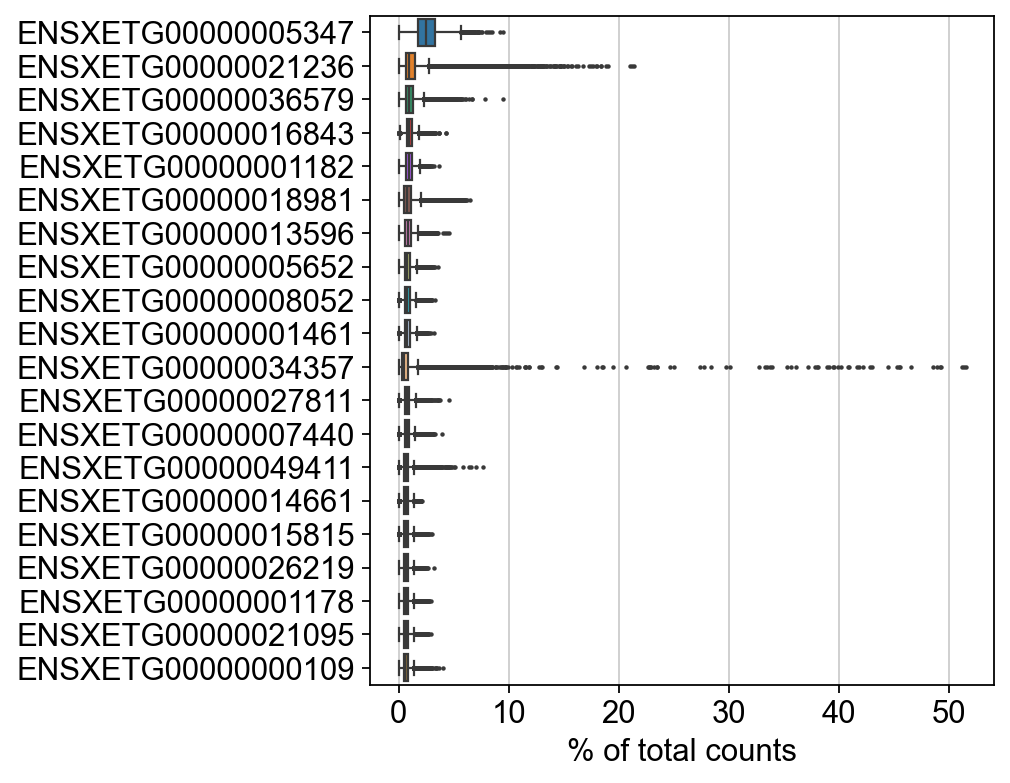

In [11]:
# Shows the genes that yield the highest fraction of counts in each single cell, across all cells.

sc.pl.highest_expr_genes(adata, n_top=20)

In [12]:
adata_copy = adata.copy()

In [13]:
sc.pp.filter_cells(adata, min_genes=100) 
sc.pp.filter_genes(adata, min_cells=3)
print(adata.shape) 

filtered out 41 cells that have less than 100 genes expressed
filtered out 11284 genes that are detected in less than 3 cells
(37613, 13330)


### Mitochondrial QC and general measures
Check if genes are annotated as mt by running:
- GENES= list(adata.var.index[adata.var.index.str.startswith('mt-'.upper())])
- GENES

In case the genes are not annotated as 'MT-'' (Like in bats), run:

- dict_replace = {'COX1':'MT-COX1','COX2':'MT-COX2'...etc}
- adata.var.rename(dict_replace, inplace = True)

In [14]:
dict_replace = {'COX1':'MT-COX1','COX2':'MT-COX2','COX3':'MT-COX3','ND1':'MT-ND1-1','ND1':'MT-ND1-2','ND2':'MT-ND2',
                'ND3':'MT-ND3','ND4':'MT-ND4','ND5':'MT-ND5','ND6':'MT-ND6','ND4L-1':'MT-ND4L','ATP6':'MT-ATP6','ATP8':'MT-ATP8',
                'CYTB':'MT-CYTB'}
adata.var.rename(dict_replace, inplace=True)
# ONLY MT-ATP6, MT-ND1, MT-ND4L

In [16]:
adata.var['MT'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

In [17]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

### Scatter plots of QC metrics

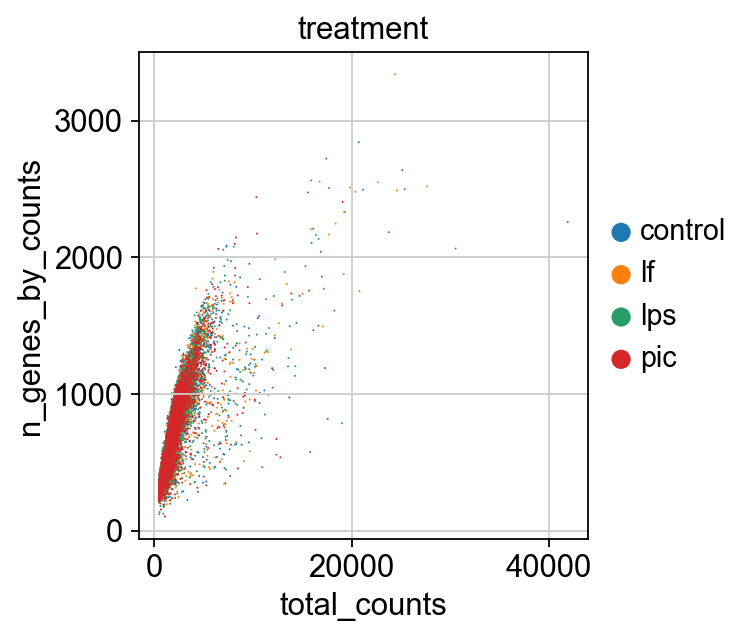

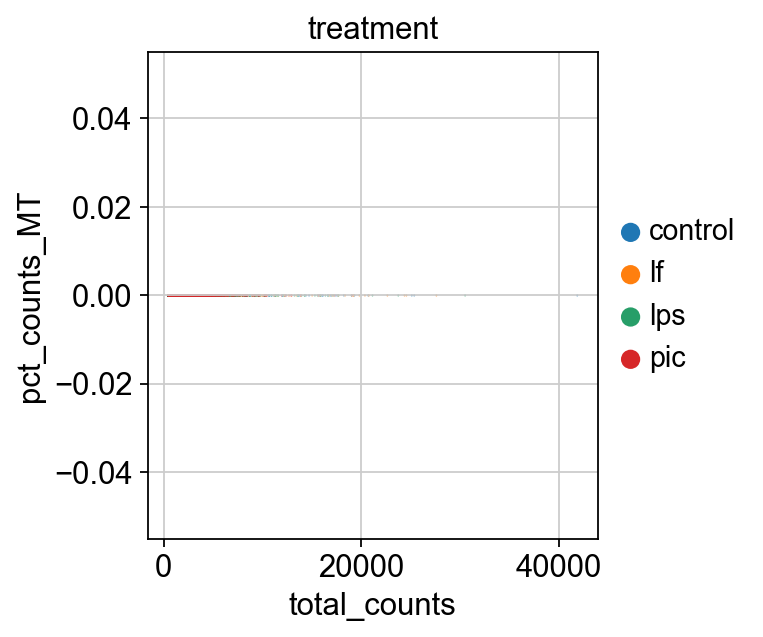

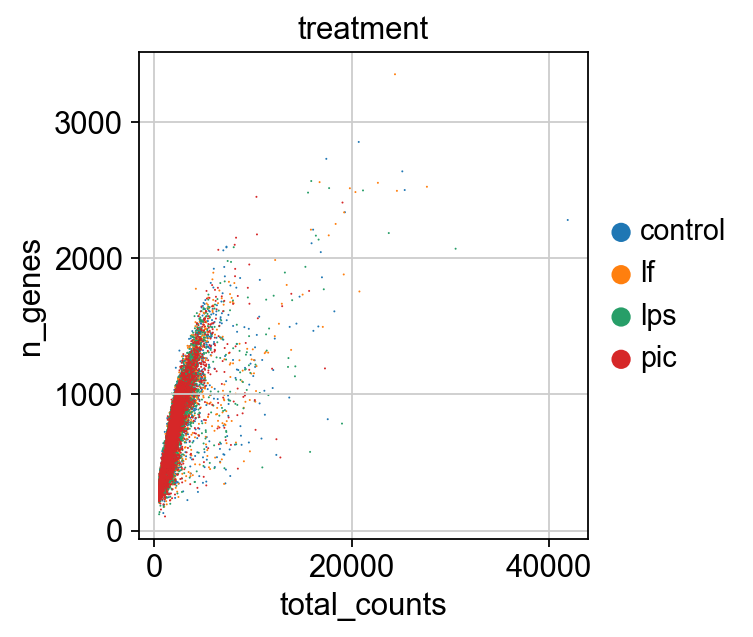

In [18]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='treatment')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT', color='treatment')
sc.pl.scatter(adata, x='total_counts', y='n_genes', color='treatment', save=True)

Actually do the filtering by slicing the AnnData object - By pct_counts_MT  and by total_counts /n_genes_by_counts or even n_genes

In [19]:
adata = adata[adata.obs.pct_counts_MT < 20] 
adata = adata[adata.obs.total_counts < 5000, :] # If filtering outliers (<0.1% of cells)

## Doublet analysis and filtering

In [20]:
import scrublet as scr

def scrub(adatas, adata, adata_names):  # based on raw individual samples. 
    print('Before scrublet: ', adata.shape[0])
    doub_index = []
    barcodes = []
    for data,name in zip(adatas, adata_names):
        data.raw = data
        sc.pp.normalize_total(data, target_sum=1e4)
        sc.pp.log1p(data)
        scrub = scr.Scrublet(data.raw.X)
        data.obs['doublet_scores'], data.obs['predicted_doublets'] = scrub.scrub_doublets()
        scrub.plot_histogram()
        print('Doublets' + name + ' :', data.obs[data.obs['doublet_scores'] > 0.25].shape[0])
        barcodes = data.obs[data.obs['doublet_scores'] < 0.25].index.to_list()
        for barcode in barcodes:
            doub_index.append(barcode + '-' + name)

    adata = adata[adata.obs.index.isin(doub_index)]
    print('After scrublet: ', adata.shape[0])
    return adata

Before scrublet:  37015
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.70
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 2.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.6%
Elapsed time: 11.8 seconds
Doubletscontrol : 1085
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 6.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.3%
Elapsed time: 26.3 seconds
Doubletslf : 759
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 0.9%
Estimated detectable doublet fraction = 8.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.4%
Elapsed time: 19.0 seconds
Doubletslps : 469
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 7.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.6%
Elapsed time: 7.8 seconds
Doubletspic : 682
After scrublet:  34100


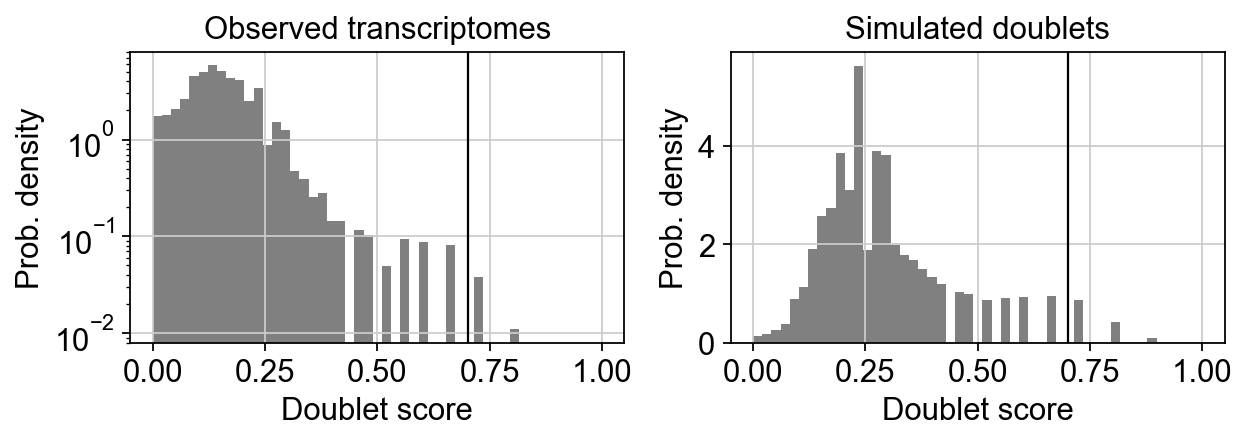

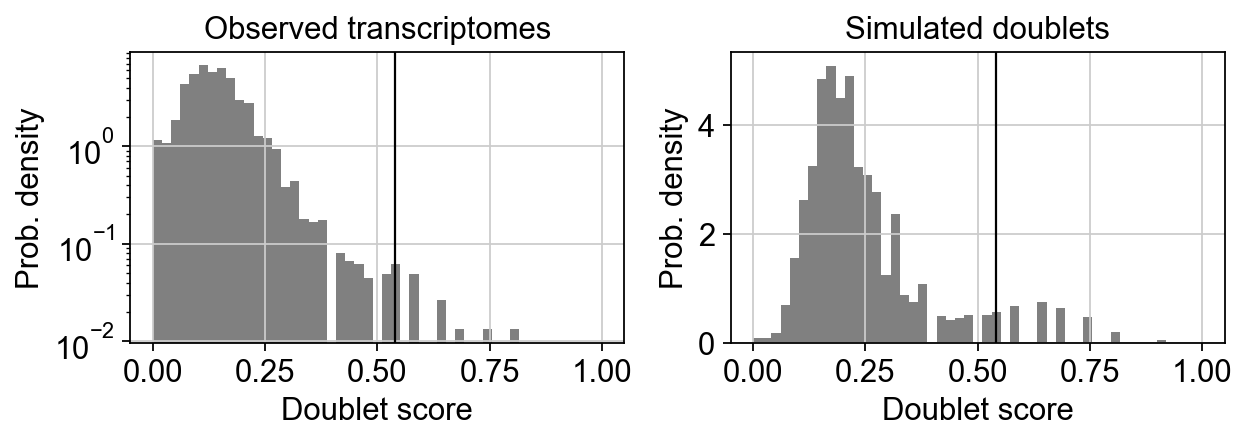

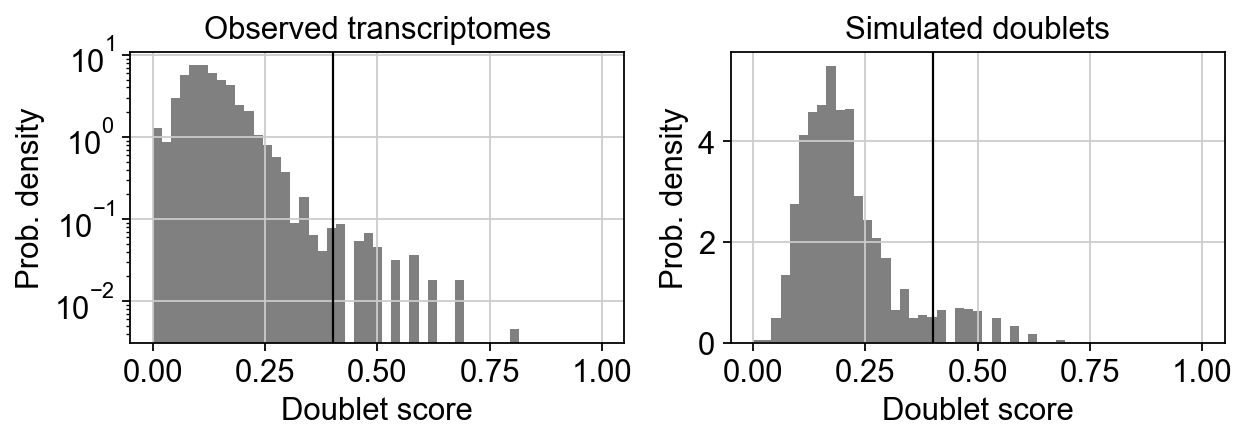

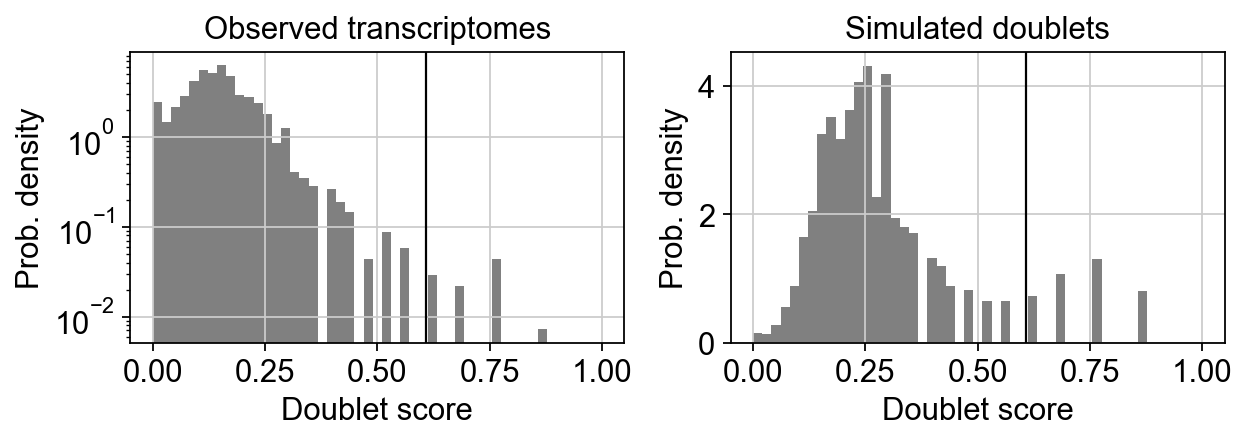

In [21]:
adata = scrub(adatas, adata, data_names)

## Cell cycle scoring

download Cell cycle txt: https://github.com/scverse/scanpy_usage/blob/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt

In [22]:
cell_cycle_genes = [x.strip() for x in open(r'/Code/data/single_cell/animals/regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

In [23]:
adata.var_names

Index(['ENSXETG00000042394', 'ENSXETG00000041794', 'ENSXETG00000042931',
       'ENSXETG00000037518', 'ENSXETG00000047867', 'ENSXETG00000022434',
       'ENSXETG00000039430', 'ENSXETG00000027610', 'ENSXETG00000034866',
       'ENSXETG00000018866',
       ...
       'ENSXETG00000044017', 'ENSXETG00000038115', 'ENSXETG00000046776',
       'ENSXETG00000049219', 'ENSXETG00000045951', 'ENSXETG00000045794',
       'ENSXETG00000047445', 'ENSXETG00000048590', 'ENSXETG00000043541',
       'ENSXETG00000043539'],
      dtype='object', length=13330)

In [24]:
g2m_genes

[]

In [ ]:
matching_values = adata.var_names.isin(cell_cycle_genes)

matching_values

In [ ]:
cell_cycle_adata = adata.copy()

sc.pp.normalize_per_cell(cell_cycle_adata, counts_per_cell_after=1e4)
sc.pp.log1p(cell_cycle_adata)
sc.pp.scale(cell_cycle_adata)
sc.tl.score_genes_cell_cycle(cell_cycle_adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata_cc_genes = cell_cycle_adata[:, cell_cycle_genes].copy()
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase', save=True)
adata.obs['S_score'] = cell_cycle_adata.obs['S_score'].copy()
adata.obs['G2M_score'] = cell_cycle_adata.obs['G2M_score'].copy()
adata.obs['phase'] = cell_cycle_adata.obs['phase'].copy()

In [ ]:
adata

In [ ]:
adata.var

## Saving adata

In [ ]:
adata.write(r'/Code/data/single_cell/animals/frog/frog_2/laevis/''frog_2_after_qc.h5ad')

## Preparing files to be opened in R studio

In [ ]:
# Preparing files to be opened in R studio

matrix_dense = adata.X.toarray()

# Create a DataFrame from the dense array with observation names as index and variable names as columns
matrix_df = pd.DataFrame(matrix_dense, index=adata.obs_names, columns=adata.var_names)

# Save the DataFrame to a CSV file
matrix_df.to_csv(r'/Code/data/single_cell/animals/turtle/turtle_3/''matrix_new.csv')
print('matrix file is transformed')

#save obs as scv
adata.obs.to_csv(r'/Code/data/single_cell/animals/turtle/turtle_3/''obs_new.csv')
print('obs file is transformed')

# Save variable data to a CSV file
adata.var.to_csv(r'/Code/data/single_cell/animals/turtle/turtle_3/''var_new.csv')
print('var file is transformed')